In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:85% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

In [2]:
import numpy as np
import pandas as pd
import sys
from tensorflow.keras import utils # utils.to_categorical 원핫인코딩
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from matplotlib import pyplot as plt

# 로지스틱회귀분석(이진분류)
## 1. 데이터셋 생성 & 전처리

In [3]:
df = pd.read_csv('data/pima-indians-diabetes.csv', 
                 comment='#',
                 header=None)
df.info() # 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       768 non-null    int64  
 1   1       768 non-null    int64  
 2   2       768 non-null    int64  
 3   3       768 non-null    int64  
 4   4       768 non-null    int64  
 5   5       768 non-null    float64
 6   6       768 non-null    float64
 7   7       768 non-null    int64  
 8   8       768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
# 타겟 변수의 균형
df.iloc[:,-1].value_counts()

0    500
1    268
Name: 8, dtype: int64

In [5]:
df.head()
# X_data = df.iloc[,:-1].values

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
# csv 파일을 numpy 로 읽어오기 : np.loadtxt(결측치가없는경우), np.genfromtxt(결측치있을 경우)
dataset = np.loadtxt('data/pima-indians-diabetes.csv', 
                    encoding='utf-8',
                    delimiter=',')
dataset.shape

(768, 9)

In [7]:
# 데이터 분할 : 학습데이터셋(모델학습용)+시험데이터셋(모델평가용)
X_train = dataset[:700, :-1]
y_train = dataset[:700, -1]
X_test  = dataset[700:, :-1]
y_test  = dataset[700:, -1]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((700, 8), (700,), (68, 8), (68,))

## 2. 모델 구성

In [8]:
model = Sequential()
model.add(Input(shape=(8,)))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1,  activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


## 3. 학습과정 설정

In [9]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['binary_accuracy'])

## 4. 학습

In [10]:
%%time
hist = model.fit(X_train, y_train, # 훈련데이터
                epochs=200, # 학습횟수
                batch_size=350, # 한번에 읽어들이는 데이터 양
                # validation_data=(X_test, y_test), # 검증데이터
                # validation_split=0.1, 
                verbose=0 # 학습 로그 출력 여부(0:출력X, 1:출력O, 2:출력자세히O)
                )

CPU times: total: 1.56 s
Wall time: 1.37 s


## 5. 모델 평가하기(학습과정 보기, 평가, 혼동행렬)

In [11]:
hist.history.keys()

dict_keys(['loss', 'binary_accuracy'])

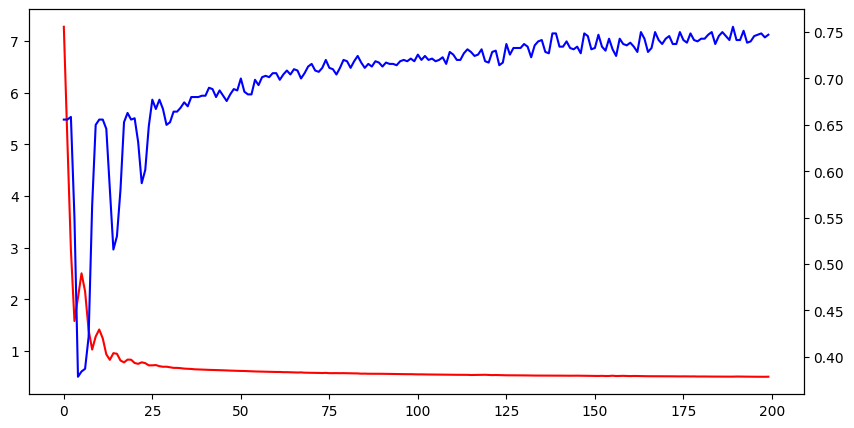

In [12]:
# 학습과정 표시(학습데이터에 대한 loss와 accuracy)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax
acc_ax.plot(hist.history.get('binary_accuracy'), 'b')

In [13]:
# 모델 평가(X)
model.evaluate(X_train, y_train)

22/22 [==============================] - 0s 1ms/step - loss: 0.5044 - binary_accuracy: 0.7457


[0.5044279098510742, 0.7457143068313599]

In [14]:
# 모델 평가(O)
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 2ms/step - loss: 0.6886 - binary_accuracy: 0.6324


[0.6886334419250488, 0.6323529481887817]

## 혼동행렬
- 테스트 데이터 셋의 실제값과 예측값으로 작성된 교차표

In [15]:
y_test[:5]

array([0., 1., 1., 0., 0.])

In [16]:
# 실제값 : y_test (68개)
# 예측값
y_hat = (model.predict(X_test)>=0.5).astype(float)

3/3 [==============================] - 0s 1ms/step


In [17]:
TN = 0  # 0을 0으로 예측한 경우의 수(T)
FP = 0  # 0을 1로 예측한 경우의 수(F)
FN = 0  # 1을 0으로 예측한 경우의 수(F)
TP = 0  # 1을 1로 예측한 경우의 수(T)
print(y_test.shape, y_hat.shape)
for y, h in zip(y_test, y_hat.reshape(-1)):
    if y==0 and h==0:
        TN += 1
    elif y==0 and h==1:
        FP += 1
    elif y==1 and h==0:
        FN += 1
    else:
        TP += 1
print(TN, FP)
print(FN, TP)

(68,) (68, 1)
34 7
18 9


In [18]:
# 교차표
ctab = pd.crosstab(y_test,   # 실제값
                  y_hat.reshape(-1)) # 예측값
ctab.index.name = '실제값'
ctab.columns.name = '예측값'
ctab
pd.crosstab(y_test,   # 실제값
            y_hat.reshape(-1), # 예측값
            rownames=['실제값'],
            colnames=['예측값']) 

예측값,0.0,1.0
실제값,,
0.0,34,7
1.0,18,9


In [19]:
# 혼동행렬
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,
                y_hat.reshape(-1))

array([[34,  7],
       [18,  9]], dtype=int64)

In [20]:
# accuracy
print('accuracy :', (TN+TP)/(TN+FP+FN+TP))
print('recall :', (TP)/(FN+TP))
print('precision :', (TP)/(FP+TP))

accuracy : 0.6323529411764706
recall : 0.3333333333333333
precision : 0.5625


## 6. 모델 사용

In [21]:
X_test[0]

array([  2.   , 122.   ,  76.   ,  27.   , 200.   ,  35.9  ,   0.483,
        26.   ])

In [22]:
int(model.predict(np.array([[2, 122,76,27,200,35.9,0.483,26]]))>=0.5)

1/1 [==============================] - 0s 23ms/step


0

In [23]:
(model.predict([[2, 122,76,27,200,35.9,0.483,26],
               [0, 122,76,27,200,35.9,0.483,26]])).astype(int)

1/1 [==============================] - 0s 45ms/step


array([[0],
       [0]])

# 분류분석
1. 데이터셋 생성 및 전처리 : 훈련셋(600), 검증셋(100), 테스트셋(68)
2. 모델 생성(input8, output 2) : 출력층 softmax(출력합을 1)
    * model.summary() 파라미터 수와 메모리 확인
3. 모델 학습과정 설정 : loss="categorical_crossentropy, metrics=['accuracy']
4. 모델 학습 : 훈련셋과 검증셋
5. 모델 평가 : 그래프(hist.history), 평가(테스트셋), 교차표(테스트셋)
6. 모델 저장 및 사용 : predict결과에 argmax()
 [99.2, 0.8]

## 1. 데이터 셋 생성 및 전저리

In [24]:
dataset = np.loadtxt('data/pima-indians-diabetes.csv',
                    encoding='utf-8',
                    delimiter=',')
dataset.shape

(768, 9)

In [25]:
# 훈련셋(600), 검증셋(100), 테스트셋(68)
X_train = dataset[:600, :-1]
y_train = dataset[:600, -1]
X_val = dataset[600:700, :-1]
y_val = dataset[600:700, -1]
X_test = dataset[700:, :-1]
y_test = dataset[700:, -1]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((600, 8), (600,), (100, 8), (100,), (68, 8), (68,))

In [26]:
# 타겟변수의 원핫인코딩(분류분석)
print(y_train[:5])
print(utils.to_categorical(y_train[:5]))
Y_train = utils.to_categorical(y_train)
Y_val   = utils.to_categorical(y_val)
Y_test  = utils.to_categorical(y_test)
y_train.shape, Y_train.shape, Y_val.shape, Y_test.shape

[1. 0. 1. 0. 1.]
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


((600,), (600, 2), (100, 2), (68, 2))

## 2. 모델 생성(input8, target2)
- 과적합 줄이는 단계 추가(dropout 추가)

In [27]:
from tensorflow.keras.layers import Dropout
model = Sequential()
model.add(Input(shape=(8,)))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2)) # 과적합을 해결
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=2, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                288       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                1040      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 8)                

## 3. 학습과정 설정

In [28]:
model.compile(loss='categorical_crossentropy',
             optimizer='nadam',
             metrics=['accuracy'])

## 4. 모델 학습

In [29]:
hist = model.fit(X_train, Y_train,
                epochs=300,
                validation_data=(X_val, Y_val),
                verbose=1)

Epoch 1/300
19/19 [==============================] - 1s 11ms/step - loss: 2.1711 - accuracy: 0.4333 - val_loss: 0.6519 - val_accuracy: 0.6300
Epoch 2/300
19/19 [==============================] - 0s 4ms/step - loss: 1.1458 - accuracy: 0.5283 - val_loss: 0.6673 - val_accuracy: 0.6300
Epoch 3/300
19/19 [==============================] - 0s 4ms/step - loss: 0.8785 - accuracy: 0.5750 - val_loss: 0.6592 - val_accuracy: 0.6500
Epoch 4/300
19/19 [==============================] - 0s 4ms/step - loss: 0.8592 - accuracy: 0.5733 - val_loss: 0.6675 - val_accuracy: 0.6800
Epoch 5/300
19/19 [==============================] - 0s 4ms/step - loss: 0.7507 - accuracy: 0.6217 - val_loss: 0.6646 - val_accuracy: 0.6700
Epoch 6/300
19/19 [==============================] - 0s 4ms/step - loss: 0.7661 - accuracy: 0.6500 - val_loss: 0.6637 - val_accuracy: 0.6700
Epoch 7/300
19/19 [==============================] - 0s 4ms/step - loss: 0.6879 - accuracy: 0.6400 - val_loss: 0.6601 - val_accuracy: 0.6700
Epoch 8/300


Epoch 59/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5944 - accuracy: 0.7017 - val_loss: 0.5974 - val_accuracy: 0.7100
Epoch 60/300
19/19 [==============================] - 0s 3ms/step - loss: 0.6071 - accuracy: 0.6767 - val_loss: 0.6018 - val_accuracy: 0.7100
Epoch 61/300
19/19 [==============================] - 0s 4ms/step - loss: 0.6069 - accuracy: 0.6650 - val_loss: 0.5964 - val_accuracy: 0.7000
Epoch 62/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5991 - accuracy: 0.6817 - val_loss: 0.5913 - val_accuracy: 0.7000
Epoch 63/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5977 - accuracy: 0.6950 - val_loss: 0.5947 - val_accuracy: 0.7100
Epoch 64/300
19/19 [==============================] - 0s 3ms/step - loss: 0.6008 - accuracy: 0.6767 - val_loss: 0.5988 - val_accuracy: 0.7100
Epoch 65/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5785 - accuracy: 0.6950 - val_loss: 0.6001 - val_accuracy: 0.7200
Epoch 

19/19 [==============================] - 0s 4ms/step - loss: 0.5732 - accuracy: 0.7017 - val_loss: 0.5825 - val_accuracy: 0.7100
Epoch 117/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5650 - accuracy: 0.7067 - val_loss: 0.5698 - val_accuracy: 0.7300
Epoch 118/300
19/19 [==============================] - 0s 3ms/step - loss: 0.5659 - accuracy: 0.6967 - val_loss: 0.5669 - val_accuracy: 0.7300
Epoch 119/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5737 - accuracy: 0.7083 - val_loss: 0.5744 - val_accuracy: 0.7100
Epoch 120/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5801 - accuracy: 0.6950 - val_loss: 0.5765 - val_accuracy: 0.7200
Epoch 121/300
19/19 [==============================] - 0s 3ms/step - loss: 0.5600 - accuracy: 0.7200 - val_loss: 0.5691 - val_accuracy: 0.7400
Epoch 122/300
19/19 [==============================] - 0s 3ms/step - loss: 0.5735 - accuracy: 0.7083 - val_loss: 0.5711 - val_accuracy: 0.7300
Epoch 123/300

19/19 [==============================] - 0s 4ms/step - loss: 0.5420 - accuracy: 0.7200 - val_loss: 0.5589 - val_accuracy: 0.7400
Epoch 174/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5550 - accuracy: 0.6950 - val_loss: 0.5719 - val_accuracy: 0.7100
Epoch 175/300
19/19 [==============================] - 0s 3ms/step - loss: 0.5446 - accuracy: 0.7267 - val_loss: 0.5646 - val_accuracy: 0.7200
Epoch 176/300
19/19 [==============================] - 0s 3ms/step - loss: 0.5532 - accuracy: 0.7217 - val_loss: 0.5545 - val_accuracy: 0.7300
Epoch 177/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5522 - accuracy: 0.7333 - val_loss: 0.5536 - val_accuracy: 0.7200
Epoch 178/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5388 - accuracy: 0.7267 - val_loss: 0.5594 - val_accuracy: 0.7200
Epoch 179/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5607 - accuracy: 0.7183 - val_loss: 0.5661 - val_accuracy: 0.7200
Epoch 180/300

19/19 [==============================] - 0s 4ms/step - loss: 0.5338 - accuracy: 0.7267 - val_loss: 0.5494 - val_accuracy: 0.7200
Epoch 231/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5286 - accuracy: 0.7383 - val_loss: 0.5555 - val_accuracy: 0.7000
Epoch 232/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5277 - accuracy: 0.7367 - val_loss: 0.5487 - val_accuracy: 0.7000
Epoch 233/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5441 - accuracy: 0.7233 - val_loss: 0.5658 - val_accuracy: 0.7000
Epoch 234/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5111 - accuracy: 0.7450 - val_loss: 0.5439 - val_accuracy: 0.7100
Epoch 235/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5062 - accuracy: 0.7500 - val_loss: 0.5646 - val_accuracy: 0.7100
Epoch 236/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5319 - accuracy: 0.7367 - val_loss: 0.5607 - val_accuracy: 0.7000
Epoch 237/300

19/19 [==============================] - 0s 4ms/step - loss: 0.5002 - accuracy: 0.7517 - val_loss: 0.5640 - val_accuracy: 0.6900
Epoch 288/300
19/19 [==============================] - 0s 4ms/step - loss: 0.4961 - accuracy: 0.7450 - val_loss: 0.5511 - val_accuracy: 0.7000
Epoch 289/300
19/19 [==============================] - 0s 3ms/step - loss: 0.5230 - accuracy: 0.7433 - val_loss: 0.5778 - val_accuracy: 0.7000
Epoch 290/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5052 - accuracy: 0.7300 - val_loss: 0.5646 - val_accuracy: 0.6900
Epoch 291/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5081 - accuracy: 0.7517 - val_loss: 0.5564 - val_accuracy: 0.7200
Epoch 292/300
19/19 [==============================] - 0s 4ms/step - loss: 0.4987 - accuracy: 0.7483 - val_loss: 0.5569 - val_accuracy: 0.7100
Epoch 293/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5139 - accuracy: 0.7367 - val_loss: 0.5637 - val_accuracy: 0.7100
Epoch 294/300

## 5. 학습과정 살펴보기

In [30]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

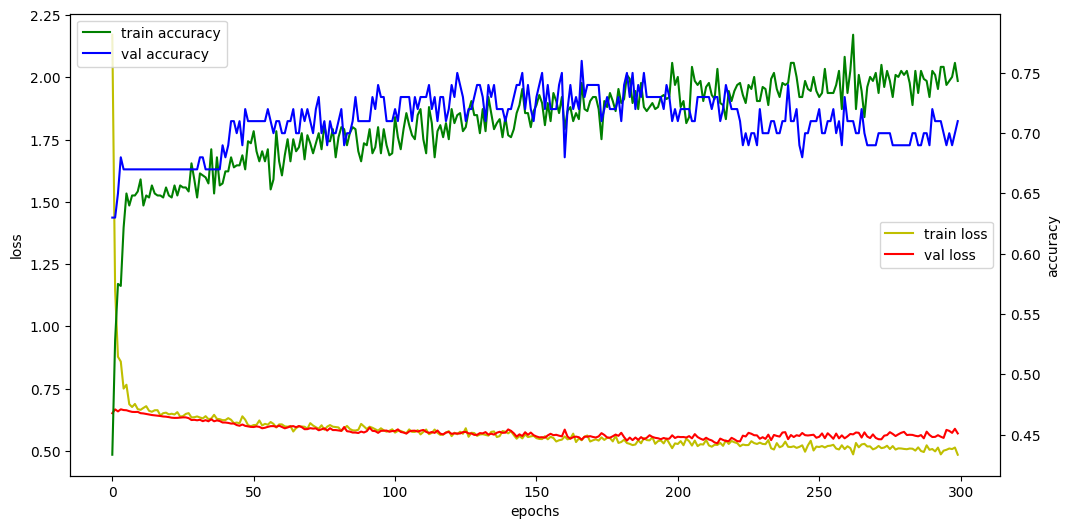

In [31]:
fig, loss_ax = plt.subplots(figsize=(12,6))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val accuracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend()
plt.show()

## 6. 모델 평가 & 교차표

In [32]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"loss : {loss}, 정확도 : {accuracy}")

loss : 0.6846415996551514, 정확도 : 0.6470588445663452


In [33]:
# 교차표
Y_test.argmax(axis=1) # 실제값 y_test

array([0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0], dtype=int64)

In [34]:
y_hat = model.predict(X_test).argmax(axis=1)
y_hat

3/3 [==============================] - 0s 2ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [35]:
pd.crosstab(y_test, y_hat, rownames=['실제값'], colnames=['예측값'])

예측값,0,1
실제값,,
0.0,41,0
1.0,24,3


In [36]:
confusion_matrix(y_test, y_hat)

array([[41,  0],
       [24,  3]], dtype=int64)

## 7. 모델 저장 및 사용

In [37]:
from tensorflow.keras.models import save_model, load_model
# model.save('model/06_pima.h5')
save_model(model, 'model/06_pima.h5')

In [38]:
model2 = load_model('model/06_pima.h5')

In [39]:
pred = model2.predict([[2, 122,  76,  27, 200,  35.9,   0.483, 26 ],
               [6, 125,  78,  31,   0,  27.6, 0.565,   49]])
pred.argmax(axis=1)

1/1 [==============================] - 0s 75ms/step


array([0, 0], dtype=int64)

In [40]:
np.argmax(pred, axis=1)

array([0, 0], dtype=int64)